## `-> Importing Libraries`

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.spatial import ConvexHull

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import joblib 
import pickle

In [2]:
data = pd.read_csv('../data/Mall_Customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
data.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

## `1. Data Preprocessing`

### `1.1 Handling Null values`

In [6]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

- No NULL VALUES

### `1.2 Handling Duplicated Data`

In [7]:
int(data.duplicated().sum())

0

- No Duplicates

### `1.3 Handling Data Types`

In [8]:
data.dtypes.value_counts()

int64     4
object    1
Name: count, dtype: int64

In [9]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [10]:
data.dtypes.value_counts()

int64     4
object    1
Name: count, dtype: int64

### `1.4 Handling Column Names`

In [11]:
try:
    data.insert(loc = len(data.columns), column = 'Spending Score', value = data['Spending Score (1-100)'])
    data.insert(loc = len(data.columns)-2, column = 'Annual Income', value = data['Annual Income (k$)'])
    data = data.drop(columns=['Annual Income (k$)', 'Spending Score (1-100)'])
except: pass
data.head()

,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## `2. Exploratory Data Analysis`

### `2.1 Visualizing each Column`

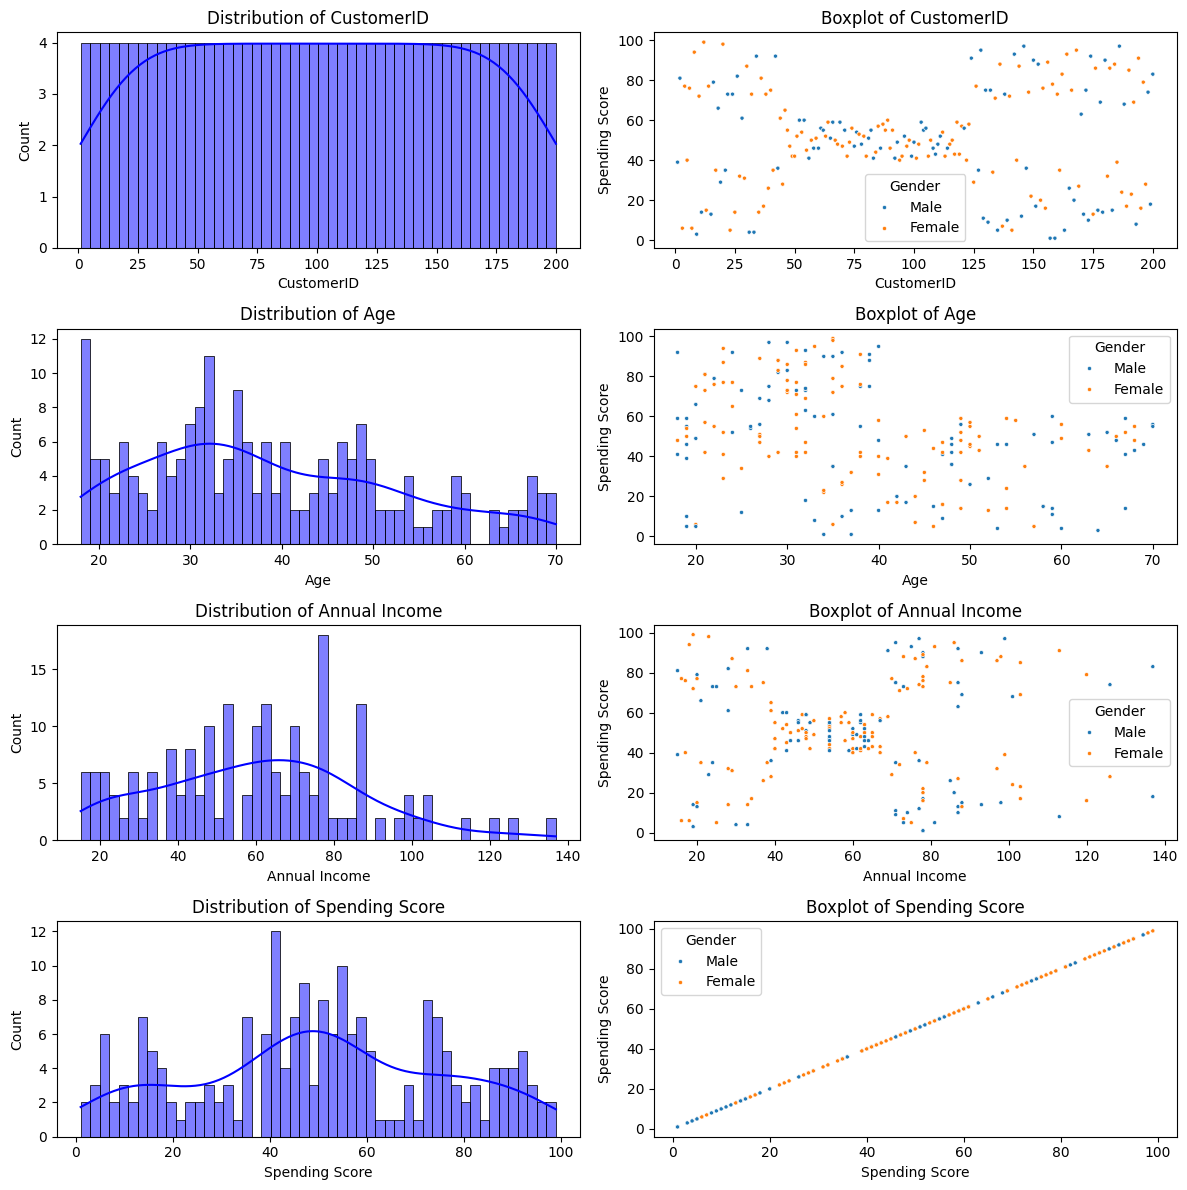

In [12]:
cols = list(data.dtypes[data.dtypes == 'int64'].index)

fig, ax = plt.subplots(nrows=len(cols), ncols=2, figsize=(12, len(cols) * 3))

for index, col in enumerate(cols):
    sns.histplot(data=data, x=col, bins=50, kde=True, ax=ax[index, 0], color='blue')
    sns.scatterplot(data = data,x=data[col], y=data['Spending Score'], ax=ax[index, 1], color = 'blue', hue='Gender', hue_order=['Male', 'Female'], marker = '.')
    
    ax[index, 0].set_title(f'Distribution of {col}')
    ax[index, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

### `2.2 Visualizing Data Distribution Relative to Gender`

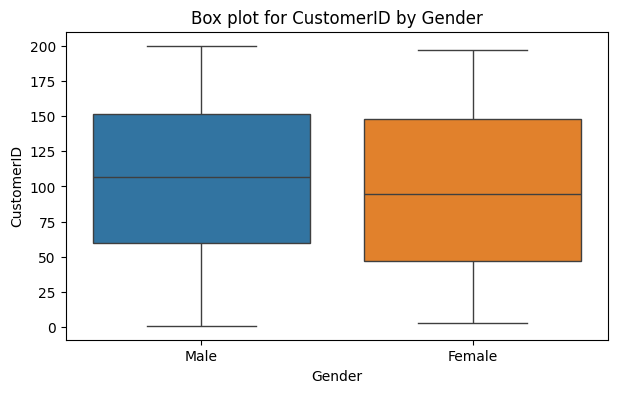

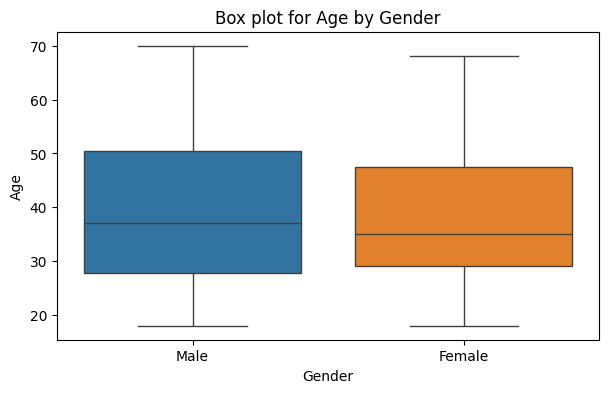

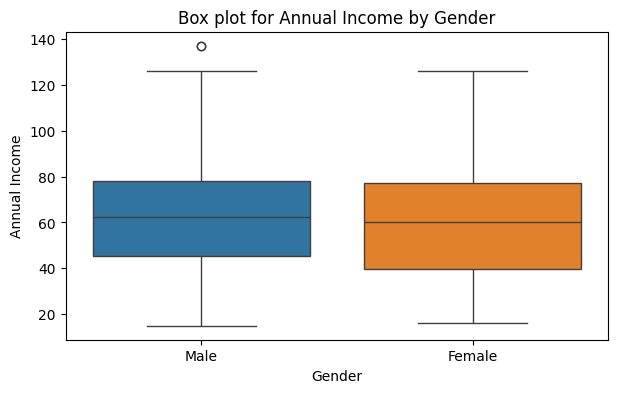

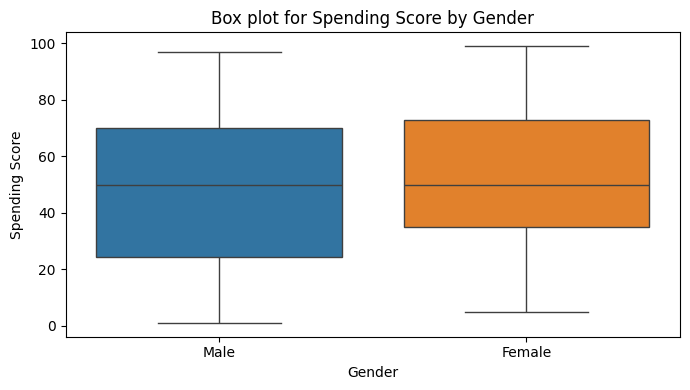

In [13]:
for column in cols:
    if(column == 'Gender'): continue
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=data, x='Gender', y=column, hue='Gender' )
    plt.title(f'Box plot for {column} by Gender')

plt.tight_layout()
plt.show()

### `2.3 Visualizing Gender Distribution`

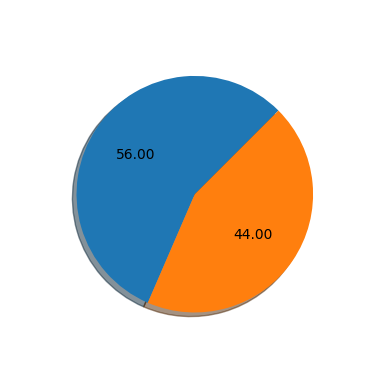

In [14]:
plt.pie(x = data['Gender'].value_counts(), autopct = '%.2f',startangle=45, normalize=True, shadow = True, radius = 0.8)
plt.show()

### `2.4 Visualizing Clusters using pairplot`

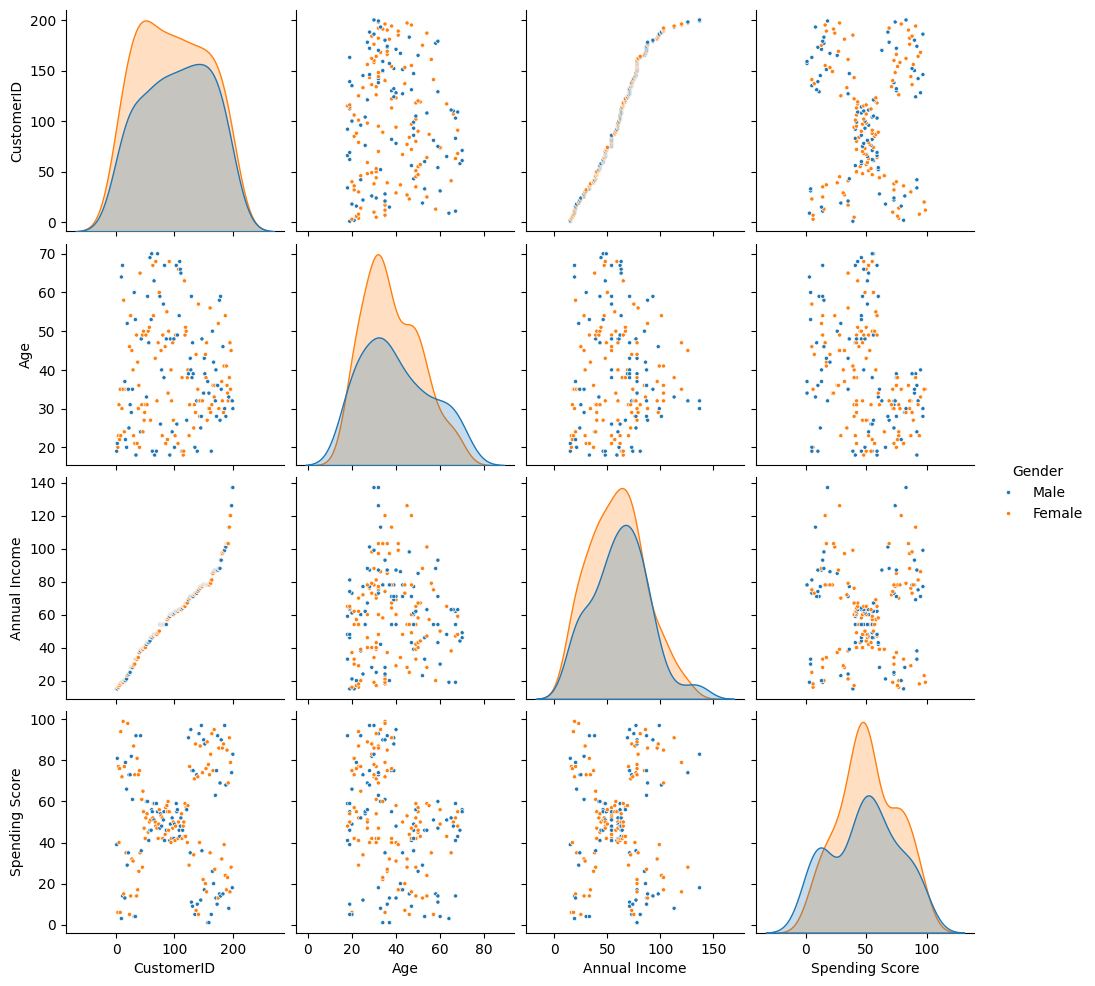

In [15]:
sns.pairplot(data = data, hue = 'Gender', hue_order=['Male', 'Female'], markers = '.')

plt.show()

### `2.5 Annual Income and Spending Score`

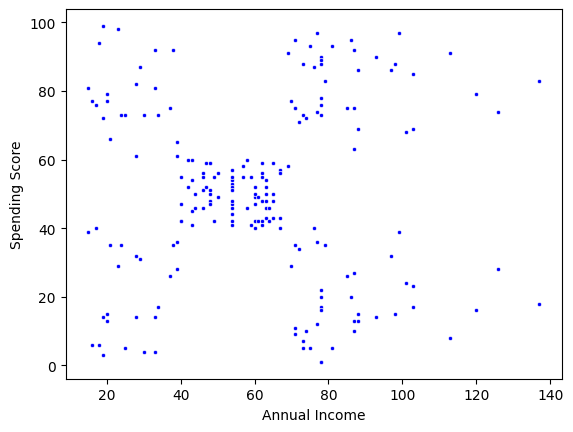

In [16]:
sns.scatterplot(x = data['Annual Income'], y = data['Spending Score'], marker = '.', color = 'blue')
plt.show()

## `3. Model Training`

### `3.1 Finding Optimal Number of Clusters`

In [17]:
fdata = data.loc[:, ['Annual Income', 'Spending Score']]
fdata.head()

,Annual Income,Spending Score
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


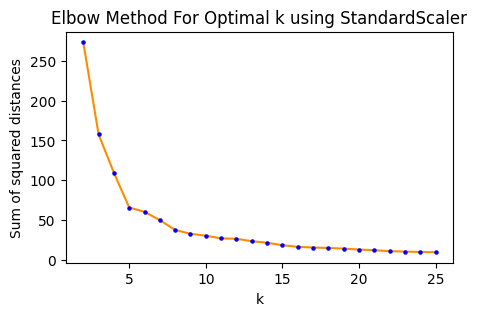

scaler used StandardScaler() 
n_clusters = 25 
elbow_score 9.306358985817173


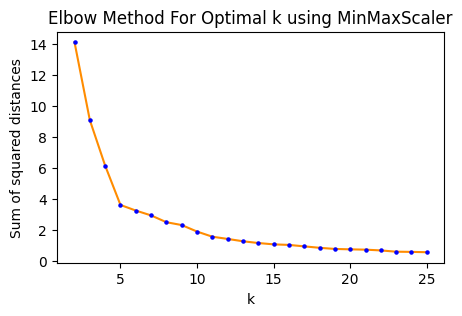

scaler used MinMaxScaler() 
n_clusters = 25 
elbow_score 0.5344498770633594


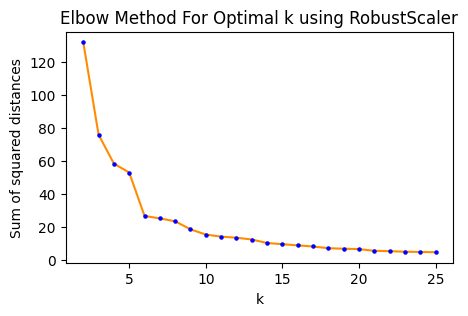

scaler used RobustScaler() 
n_clusters = 25 
elbow_score 4.904717474287855


In [18]:
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
model = KMeans()

for scaler in scalers:
    sosd = dict()
    data_scaled = scaler.fit_transform(fdata)
    K = range(2, 26)
    for k in K:
        km = KMeans(n_clusters=k, random_state=42)
        km = km.fit(data_scaled)
        sosd[k] = (km.inertia_)

    sorted_sosd = {key: value for key, value in sorted(sosd.items(), key=lambda item: item[1])}
    
    plt.figure(figsize=(5, 3))
    
    plt.scatter(K, sosd.values(), color='blue', s = 20, marker = '.', zorder = 5)
    sns.lineplot(x=K, y=sosd.values(), color='darkorange')
    
    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.title(f'Elbow Method For Optimal k using {scaler.__class__.__name__}')
    plt.show()
    first_key, first_value = next(iter(sorted_sosd.items()))
    
    print(f"scaler used {scaler} \nn_clusters = {first_key} \nelbow_score {first_value}")

---
- Best Scaler to use is MinMaxScaler()
---

### `3.2 Creating Training Pipeline`

In [19]:
def best_n_cluster_value():
    silhouette_scores = []
    
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(fdata)
    
    min_score = -1
    n_clus = 0
    threshold = 0
    for k in range(2, 20):
        km = KMeans(n_clusters=k, random_state=42, verbose = 0)
        km = km.fit(data_scaled)
        clusters = km.predict(data_scaled)

        sil_score = silhouette_score(data_scaled, clusters)
        
        if sil_score < min_score:
            threshold+=1
        
        if sil_score > min_score:
            min_score = sil_score
            n_clus = k
            threshold = 0
            
    return n_clus
        
    
best_nclus = best_n_cluster_value()
print(best_nclus)

5


In [20]:
def best_params_for_clustering(k):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(fdata)

    param = {
        'init' : ['k-means++', 'random'],
        'max_iter' : np.arange(1,50,1),
        'tol' : [0.001, 0.0001, 0.00001],
        'random_state' : [0,1,123,42],
        'algorithm' : ['lloyd', 'elkan']
        
    }
    
    gs = GridSearchCV(estimator=KMeans(n_clusters=k), param_grid=param, n_jobs = -1, cv = 10, verbose = 4)
    gs.fit(data_scaled)
    
    return gs.best_params_, data_scaled
    

best_params, data_scaled = best_params_for_clustering(best_nclus)
print(best_params)

Fitting 10 folds for each of 2352 candidates, totalling 23520 fits
{'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': np.int64(2), 'random_state': 1, 'tol': 0.001}


In [21]:
def training(params, k):
    model = KMeans(n_clusters=k, 
                   algorithm = params['algorithm'], 
                   init = params['init'], 
                   max_iter = params['max_iter'], 
                   random_state = params['random_state'], 
                   tol = params['tol'])
    
    print(model)
    trained_model = model.fit(data_scaled)
    labels = trained_model.labels_
    print(silhouette_score(data_scaled, labels))
    
    return trained_model

trained_model = training(best_params, best_nclus)
trained_model

KMeans(max_iter=np.int64(2), n_clusters=5, random_state=1, tol=0.001)
0.5602436353739457


KMeans(max_iter=np.int64(2), n_clusters=5, random_state=1, tol=0.001)

In [22]:
trained_model.inertia_

3.5834407128859738

## `4. Model Evaluation`

In [33]:
pd.DataFrame(data_scaled).head()

,0,1
0,0.000000,0.387755
1,0.000000,0.816327
2,0.008197,0.051020
3,0.008197,0.775510
4,0.016393,0.397959


In [23]:
labels = trained_model.predict(data_scaled)
centroids = trained_model.cluster_centers_

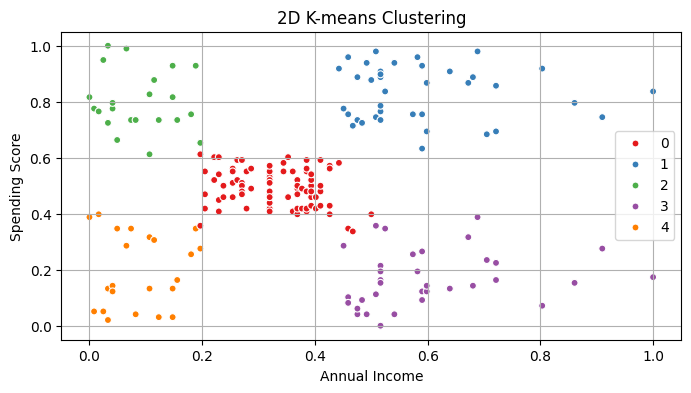

In [24]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x=data_scaled[:, 0], y=data_scaled[:, 1], hue=labels, palette='Set1', s=100, alpha=1, marker = '.')
plt.title('2D K-means Clustering')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.grid(True)
plt.show()

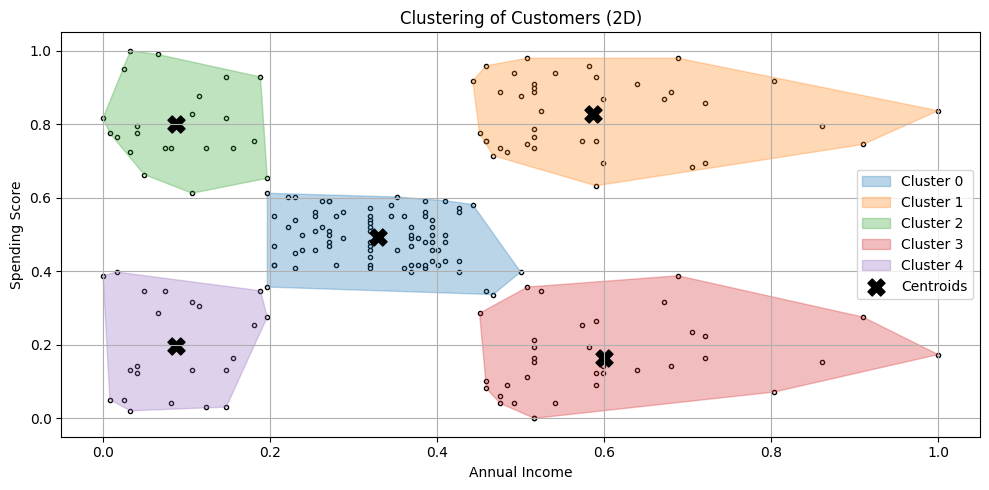

In [25]:
cluster_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.figure(figsize=(10, 5))

# Plot clusters
for i, color in enumerate(cluster_colors):
    cluster_points = data_scaled[labels == i]
    hull = ConvexHull(cluster_points)
    plt.scatter(data_scaled[labels == i, 0], data_scaled[labels == i, 1], 
                c='white', marker='.', edgecolors='black')
    plt.fill(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1], 
             c=color, alpha=0.3, label=f'Cluster {i}')

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', label='Centroids', marker='X', s=150)

plt.legend()
plt.title('Clustering of Customers (2D)')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.grid(True)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels

plt.show()

## `5. Exporting the model`

In [31]:
joblib.dump(value = trained_model, filename='../models/customer_clustering.pkl')

['../models/customer_clustering.pkl']